In [224]:
import re
import pandas as pd
import numpy as np
import csv
import string
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
plt.style.use('ggplot')

from sklearn import naive_bayes
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer(ngram_range=(1,2))
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_transformer = TfidfTransformer()

### 1. Read in train and test data from another module

In [254]:
def import_train_test_data():
    import Read_process_split_tweets
    x_train, x_test, y_train, y_test = Read_process_split_tweets.split_tweets()
    return (x_train, x_test, y_train, y_test)

### 2. Vectorize tweets

In [255]:
def save_count_vectorizer():
    count_vectorizer_fit = count_vect.fit(import_train_test_data()[0])

    saved_count_vectorizer = 'count_vectorizer.pickle'
    pickle.dump(count_vectorizer_fit, open(saved_count_vectorizer, 'wb'))
    loaded_count_vectorizer = pickle.load(open(saved_count_vectorizer, 'rb'))
    
    return loaded_count_vectorizer

In [256]:
def save_tfidf_vectorizer():
    tfidf_vect_fit = tfidf_vect.fit(split_data()[0])
    
    saved_tfidf_vectorizer = 'tfidf_vectorizer.pickle'
    pickle.dump(tfidf_vect_fit, open(saved_tfidf_vectorizer, 'wb'))
    loaded_tfidf_vectorizer = pickle.load(open(saved_tfidf_vectorizer, 'rb'))
    
    return loaded_tfidf_vectorizer

In [257]:
def vectorize_data():
    loaded_count_vectorizer = save_count_vectorizer()
    loaded_tfidf_vectorizer = save_tfidf_vectorizer()
    
    x_train_cvec = loaded_count_vectorizer.transform(import_train_test_data()[0]).toarray()
    x_test_cvec = loaded_count_vectorizer.transform(import_train_test_data()[1]).toarray()
    
    x_train_tfidf = loaded_tfidf_vectorizer.transform(import_train_test_data()[0]).toarray()
    x_test_tfidf = loaded_tfidf_vectorizer.transform(import_train_test_data()[1]).toarray()
    
    return (x_train_cvec, x_test_cvec, x_train_tfidf, x_test_tfidf)

### 3. Compare models and choose the best one
#### Multinomial Naive Bayes turns out to have the highest accuracy on test data

In [258]:
def compare_models():
    models_list = [RandomForestClassifier(), LinearSVC(), 
                   MultinomialNB(), LogisticRegression()]
    scores_dict_count_vectorizer = {}
    scores_dict_tfidf = {}
    
    for model in models_list:
        model.fit(vectorize_data()[0], import_train_test_data()[2])
        score_count_vectorizer = model.score(vectorize_data()[1], import_train_test_data()[3])
        score_count_tfidf = model.score(vectorize_data()[3], import_train_test_data()[3])
        scores_dict_count_vectorizer[model] = round(score_count_vectorizer,2)
        scores_dict_tfidf[model] = round(score_count_tfidf,2)
      
    print ('\033[1m' + "The accuracies of models on test set, using count vectorizer are:", scores_dict_count_vectorizer)
    print("\n")
    print ('\033[1m' + "The accuracies of models on test set, using TFIDF are:", scores_dict_tfidf)
    print("\n")
    print (colored("Multinomial Naive Bayes, using count vectorizer, has the highest accuracy on test data", 'blue', attrs=['bold']))

In [259]:
compare_models()

The accuracies of models on test set, using count vectorizer are: {RandomForestClassifier(): 0.68, LinearSVC(): 0.72, MultinomialNB(): 0.77, LogisticRegression(): 0.74}


The accuracies of models on test set, using TFIDF are: {RandomForestClassifier(): 0.55, LinearSVC(): 0.55, MultinomialNB(): 0.74, LogisticRegression(): 0.55}


Multinomial Naive Bayes, using count vectorizer, has the highest accuracy on test data


#### 3.1 Save Multinomial Naive Bayes model

In [260]:
def save_best_model():
    chosen_model = MultinomialNB().fit(vectorize_data()[0], import_train_test_data()[2])
    saved_model = 'finalized_model.sav'
    pickle.dump(chosen_model, open(saved_model, 'wb'))
    loaded_model = pickle.load(open(saved_model, 'rb'))
    
    return (loaded_model)

### 4. Calculate accuracy metrics

In [261]:
def accuracy_metrics():
    loaded_model = save_best_model()
    tweets_text_df = clean_data()
    
    y_pred = loaded_model.predict(vectorize_data()[1])
    conf_mat = confusion_matrix(import_train_test_data()[3], y_pred)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion matrix")
    plt.show()

    print(metrics.classification_report(import_train_test_data()[3], y_pred))

In [264]:
def main():
    x_train, x_test, y_train, y_test = import_train_test_data()
    text_concatenate = pd.concat([x_train, x_test])
    labels_concatenate = pd.concat([y_train, y_test])
    data = {'text': text_concatenate, 'labels': labels_concatenate}
    plot_df = pd.DataFrame(data)
    plt.figure(figsize=(10, 8))
    ax = plot_df['labels'].value_counts().plot(kind='bar')
    ax.set_title('Distribution of labels in overall data')
    print (colored("1 stands for non-conspiratorial label and 0 stands for conspiratorial label", 'blue', attrs=['bold']))
    plt.show()
    
    accuracy_metrics()

1 stands for non-conspiratorial label and 0 stands for conspiratorial label


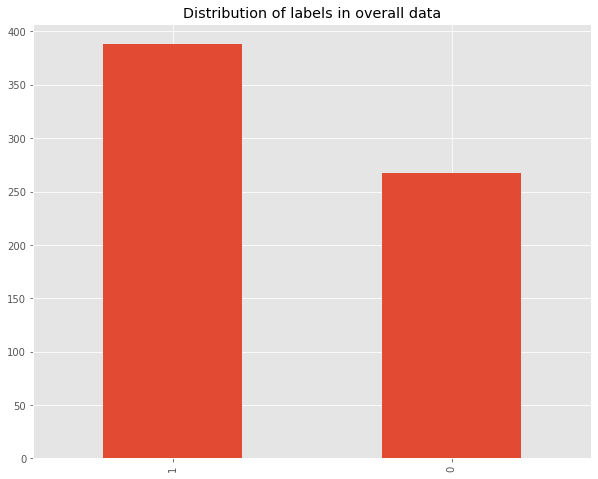

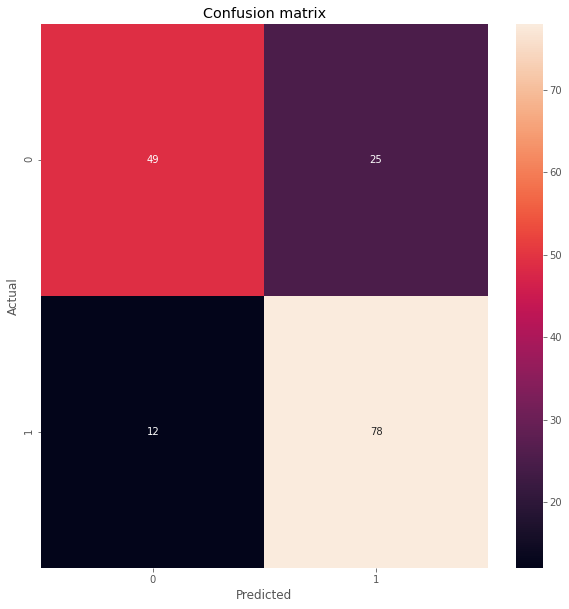

              precision    recall  f1-score   support

           0       0.80      0.66      0.73        74
           1       0.76      0.87      0.81        90

    accuracy                           0.77       164
   macro avg       0.78      0.76      0.77       164
weighted avg       0.78      0.77      0.77       164



In [265]:
main()